# 5.4 Visualizing what convnets learn
1. Visualizing intermediate convnet ouputs.
2. Visualizing convnets filters.
3. Visualizing heatmaps of class activation in an image.

## 5.4.1 Visualizing intermediate convnet ouputs.

In [19]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
from tensorflow import keras
from keras.models import load_model

model = load_model('cats_vs_dogs_small_1.h5')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 41, 41, 128)       7385

In [2]:
img_path = "/home/ubuntu/dlp_fc/chpt5/data/cats_vs_dogs_small/test/cat/cat.1700.jpg"

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (180, 180))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 180, 180, 3)


Let's display this image.

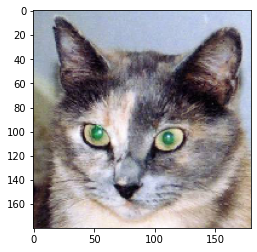

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps, creating a Keras model that takes batches of images as input, and outputs the activation of all convolution and pooling layers.

In [6]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

print(layer_outputs[2])

KerasTensor(type_spec=TensorSpec(shape=(None, 178, 178, 32), dtype=tf.float32, name=None), name='conv2d_15/Relu:0', description="created by layer 'conv2d_15'")


This is the activation of the first convolution layer for the cat image input.

In [34]:
second_conv_layer_activation = activations[4]
print(second_conv_layer_activation.shape)

(1, 87, 87, 64)


It's a 178\*178 feature map with 32 channels. Let's try ploting the fourth channel of the activation of the first conv layer of the original model.

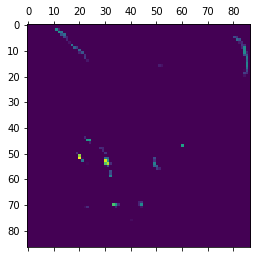

In [35]:
import matplotlib.pyplot as plt

plt.matshow(second_conv_layer_activation[0, :, :, 1], cmap='viridis')

Not sure what is doing here, seems like diagonal edge detector.

Let's extract and plot every channel in each of convolution layers, and we'll stack the results in one big image tensor.

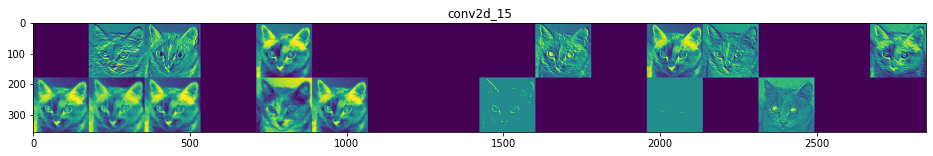

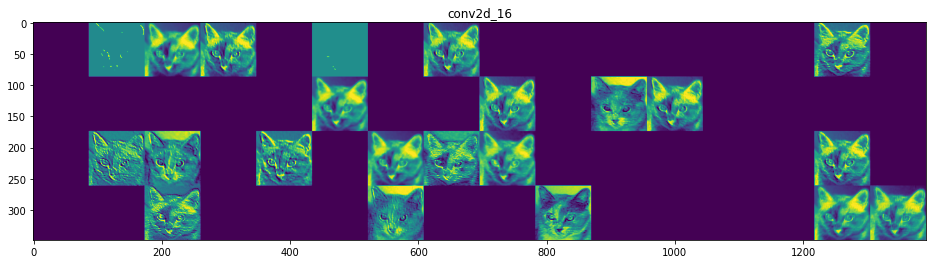

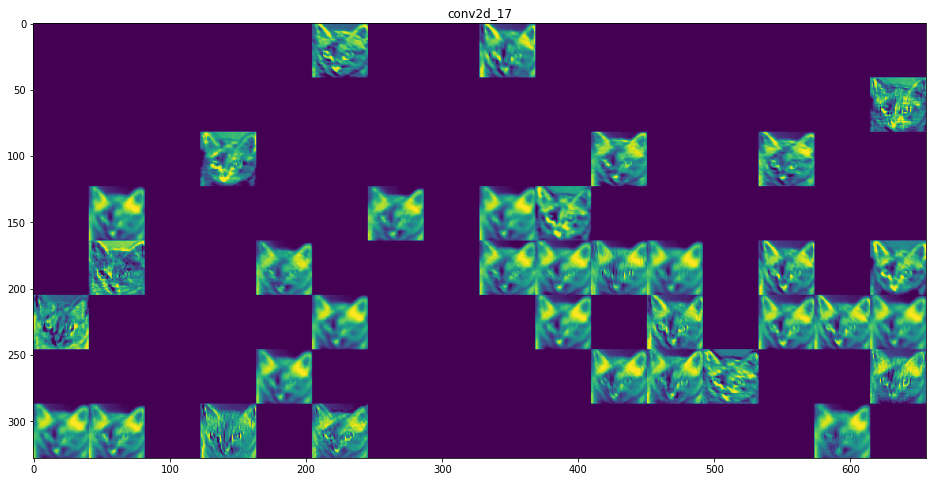

In [36]:
layer_names = []
indices = [2, 4, 6]

for index in indices:
    layer_names.append(model.layers[index].name)
    
sub_activations = [activations[2], activations[4], activations[6]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, sub_activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

1. The first layer (not first convolution layer) acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
2. As going higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts, such as "cat ear" and "cat eye". Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of image.
3. The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter is not found in the input image.

## 5.4.2 Visualizing convnet filters
Another easy to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with *gradient ascent* in *input space*: applying *gradient descent* to the value of the input image of a convnet so as to *maxmize* the response of a specific filter, starting from a blank input image. The resulting input image will be one that the choosen filter is maximally responsive to.

In [62]:
from tensorflow import keras
from keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

model = keras.applications.vgg16.VGG16(weights = 'imagenet',
                                      include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we need the gradient of this loss w.r.t the model's input.

In [63]:
grads = K.gradients(loss, model.input)

To help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm.

In [64]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Fetching Numpy output values given Numpy input values

In [ ]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])